In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # 代替elbow method
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
data = pd.read_excel('df_total.xlsx')

In [3]:
data = data[['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer','AVGX','AVGY','MacNo', 'MacRecipe', 'mtl_desc2', 'mtl_desc4', 'vend_nbr',
         'layer_2Thick', 'plate_mtl_desc1', 'plate_mtl_desc2','plate_vend_nbr', 'plate_layer_2Thick', 'plate_RC_value',
         'Residual Copper Rate', 'glass_fabric_thickness(mm)','use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
         'glass_fabric_type', 'short', 'long','bake_result', 'bake_measured','bake_after_browning_result', 'bake_after_browning_measured',
         'd_PSVarX', 'd_PSVarY']]

data = data.copy()
data['layer_2Thick'] = data['layer_2Thick'].replace('None', np.nan).astype(float)
data['layer_2Thick'] = data['layer_2Thick'].astype('float')

data['plate_mtl_desc2'] = data['plate_mtl_desc2'].astype('float')

data['MacNo'] =data['MacNo'].astype('O')
data['bake_result'] =data['bake_result'].astype('O')
data['bake_measured'] =data['bake_measured'].astype('O')
data['bake_after_browning_result'] =data['bake_after_browning_result'].astype('O')
data['bake_after_browning_measured'] =data['bake_after_browning_measured'].astype('O')

data['plate_layer_2Thick'] = pd.to_numeric(data['plate_layer_2Thick'], errors='coerce')
data = data.rename(columns={"glass_fabric_thickness(mm)": "glass_fabric_thickness_mm"})
data = data.rename(columns={"Residual Copper Rate": "Residual_Copper_Rate"})

data["glass_fabric_type"] = data["glass_fabric_type"].astype(str).str.replace(r"\+$", "", regex=True)

In [4]:
data.dtypes

Part_nbr                         object
Lot_nbr                          object
Layer                            object
d_Layer                          object
AVGX                            float64
AVGY                            float64
MacNo                            object
MacRecipe                        object
mtl_desc2                       float64
mtl_desc4                        object
vend_nbr                         object
layer_2Thick                    float64
plate_mtl_desc1                  object
plate_mtl_desc2                 float64
plate_vend_nbr                   object
plate_layer_2Thick              float64
plate_RC_value                  float64
Residual_Copper_Rate            float64
glass_fabric_thickness_mm       float64
use_cu_upper_thickness          float64
use_cu_lower_thickness          float64
use_cu_type                      object
glass_fabric_type                object
short                           float64
long                            float64


<p style = "font_size: 16; color: red;">Full Data</p>

In [5]:
df = data

# 找出小於閾值的料號列表
part_counts = df['Part_nbr'].value_counts()

threshold = 30
below_threshold_parts = part_counts[part_counts < threshold].index.tolist()

print(f"小於 {threshold} 筆數據的料號共有 {len(below_threshold_parts)} 個：")
# print(below_threshold_parts)

小於 30 筆數據的料號共有 835 個：


In [6]:
# 計算各料號的觀測數
part_counts = df['Part_nbr'].value_counts()

threshold = 30
df['Part_nbr_grouped'] = np.where(df['Part_nbr'].map(part_counts) < threshold, 'OTHER', df['Part_nbr'])

# 按分位數合併（合併底部25%）
# quantile_threshold = part_counts.quantile(0.25)
# df['Part_nbr_grouped'] = np.where(df['Part_nbr'].map(part_counts) < quantile_threshold, 'OTHER', df['Part_nbr'])

<p style = "font_size: 16; color: blue;">Modeling 前處理</p>

<p style = "font_size: 14; color: green;">RC 處理</p>

In [7]:
def categorize_plate_rc(value):
    if pd.isna(value):
        return "Missing"
    elif value >= 70:
        return "High"
    elif value <= 60:
        return "Low"
    else:
        return "Median"

df["plate_RC_cat"] = df["plate_RC_value"].apply(categorize_plate_rc)

In [8]:
features_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype=='O']

for feature in features_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

#這裡是將有nan的data挑出來，把nan換成Missing 標籤，因為等等要編碼(encode)，它不能是nan
def replace_cat_feature(data, features_nan):
    data1 = data.copy()
    data1[features_nan]=data[features_nan].fillna('Missing')
    return data1

df = replace_cat_feature(df, features_nan)

#nan沒有了，變成了Missing 標籤，所以都是0
df[features_nan].isnull().sum()

MacRecipe: 154 missing value
mtl_desc4: 782 missing value
use_cu_type: 1411 missing value


MacRecipe      0
mtl_desc4      0
use_cu_type    0
dtype: int64

<p style="font-size: 14px; color: blue;"> 找出遺失值數量(比例)</p>

In [9]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 1]

for feature in features_with_na:
    print(feature, df[feature].isnull().sum(), 'missing values')

layer_2Thick 4330 missing values
plate_layer_2Thick 24024 missing values
plate_RC_value 5811 missing values
glass_fabric_thickness_mm 782 missing values
use_cu_upper_thickness 782 missing values
use_cu_lower_thickness 782 missing values
short 3365 missing values
long 3365 missing values


<p style="font-size: 14px; color: blue;">找出有遺失值的數值型特徵<p>

In [10]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes!='O']

print('Number of features: ',len(numerical_features))

# df[numerical_features].head()

Number of features:  15


<p style="font-size: 14px; color: blue;">找出有遺失值的離散型特徵<p>

In [11]:
discrete_feature = [feature for feature in numerical_features if len(df[feature].unique())<25]
print('Discrete variables count: {}'.format(len(discrete_feature)))
discrete_feature 

Discrete variables count: 2


['use_cu_upper_thickness', 'use_cu_lower_thickness']

In [12]:
# df['use_cu_lower_thickness'].unique()

In [13]:
df['use_cu_lower_thickness'] = df['use_cu_lower_thickness'].astype('O')
df['use_cu_upper_thickness'] = df['use_cu_upper_thickness'].astype('O')

In [14]:
df['use_cu_lower_thickness'].unique()

array([1.0, 2.0, 0.5, nan, 3.0, 4.0], dtype=object)

<p style="font-size: 14px; color: blue;">找出有遺失值的類別型特徵<p>

In [15]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(len(categorical_features))
print(categorical_features)

20
['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'MacNo', 'MacRecipe', 'mtl_desc4', 'vend_nbr', 'plate_mtl_desc1', 'plate_vend_nbr', 'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type', 'glass_fabric_type', 'bake_result', 'bake_measured', 'bake_after_browning_result', 'bake_after_browning_measured', 'Part_nbr_grouped', 'plate_RC_cat']


In [16]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature, len(df[feature].unique())))

The feature is Part_nbr and number of categories are 1235
The feature is Lot_nbr and number of categories are 4206
The feature is Layer and number of categories are 17
The feature is d_Layer and number of categories are 40
The feature is MacNo and number of categories are 16
The feature is MacRecipe and number of categories are 182
The feature is mtl_desc4 and number of categories are 62
The feature is vend_nbr and number of categories are 11
The feature is plate_mtl_desc1 and number of categories are 96
The feature is plate_vend_nbr and number of categories are 9
The feature is use_cu_upper_thickness and number of categories are 6
The feature is use_cu_lower_thickness and number of categories are 6
The feature is use_cu_type and number of categories are 32
The feature is glass_fabric_type and number of categories are 64
The feature is bake_result and number of categories are 2
The feature is bake_measured and number of categories are 2
The feature is bake_after_browning_result and num

<p style="font-size: 14px; color: blue;">處理離散型遺失值<p>

In [17]:
features_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype=='O']

for feature in features_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

use_cu_upper_thickness: 782 missing value
use_cu_lower_thickness: 782 missing value


In [18]:
#這裡是將有nan的data挑出來，把nan換成Missing 標籤，因為等等要編碼(encode)，它不能是nan
def replace_cat_feature(data, features_nan):
    data1 = data.copy()
    data1[features_nan]=data[features_nan].fillna('Missing')
    return data1

df = replace_cat_feature(df, features_nan)

#nan沒有了，變成了Missing 標籤，所以都是0
df[features_nan].isnull().sum()

use_cu_upper_thickness    0
use_cu_lower_thickness    0
dtype: int64

<p style="font-size: 14px; color: blue;">處理數值型遺失值<p>

In [19]:
numerical_with_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype!='O']

for feature in numerical_with_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

layer_2Thick: 4330 missing value
plate_layer_2Thick: 24024 missing value
plate_RC_value: 5811 missing value
glass_fabric_thickness_mm: 782 missing value
short: 3365 missing value
long: 3365 missing value


In [20]:
# 先對每個數值欄位進行分群中位數填補
for feature in numerical_with_nan:
    # 新增一欄標示缺失
    df[feature + '_nan'] = np.where(df[feature].isnull(), 1, 0)
    
    # 對每個 (Part_nbr, Lot_nbr) 群組算中位數來填補
    df[feature] = df.groupby(['Part_nbr', 'Lot_nbr'])[feature]\
                        .transform(lambda x: x.fillna(x.median()))

# 若還有 NaN，用整體中位數補
for feature in numerical_with_nan:
    df[feature] = df[feature].fillna(df[feature].median())


C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.

In [21]:
df[numerical_with_nan].isnull().sum()

layer_2Thick                 0
plate_layer_2Thick           0
plate_RC_value               0
glass_fabric_thickness_mm    0
short                        0
long                         0
dtype: int64

<p style="font-size: 14px; color: blue;">處理類別型遺失值<p>

In [22]:
categorical_feattures = [feature for feature in df.columns if df[feature].dtypes=='O' ]
categorical_feattures

['Part_nbr',
 'Lot_nbr',
 'Layer',
 'd_Layer',
 'MacNo',
 'MacRecipe',
 'mtl_desc4',
 'vend_nbr',
 'plate_mtl_desc1',
 'plate_vend_nbr',
 'use_cu_upper_thickness',
 'use_cu_lower_thickness',
 'use_cu_type',
 'glass_fabric_type',
 'bake_result',
 'bake_measured',
 'bake_after_browning_result',
 'bake_after_browning_measured',
 'Part_nbr_grouped',
 'plate_RC_cat']

In [23]:
# 你想保留的欄位（不處理的）
excluded_features = ['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'Part_nbr_grouped']

# 建立一個新的列表，過濾掉 excluded_features
processed_categorical_features = [f for f in categorical_features if f not in excluded_features]

# 把字串 'nan' 轉成真正的 NaN
df[processed_categorical_features] = (
    df[processed_categorical_features].replace(['nan', 'NaN', 'NULL'], np.nan)
)

features_cat_nan = [
    feature for feature in processed_categorical_features
    if df[feature].isnull().sum() > 1 and df[feature].dtype == 'O'
]

df = replace_cat_feature(df, features_cat_nan)

# rare category 合併
# for feature in processed_categorical_features:
#     temp = df.groupby(feature)['d_PSVarX'].count() / len(df)
#     temp_df = temp[temp > 0.01].index
#     df[feature] = np.where(df[feature].isin(temp_df), df[feature], 'rare cate')

# target mean encoding
# for feature in processed_categorical_features:
#     labels_ordered = df.groupby([feature])['d_PSVarX'].mean().sort_values().index
#     labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
#     df[feature] = df[feature].map(labels_ordered)

C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_15272\1600885100.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[processed_categorical_features].replace(['nan', 'NaN', 'NULL'], np.nan)


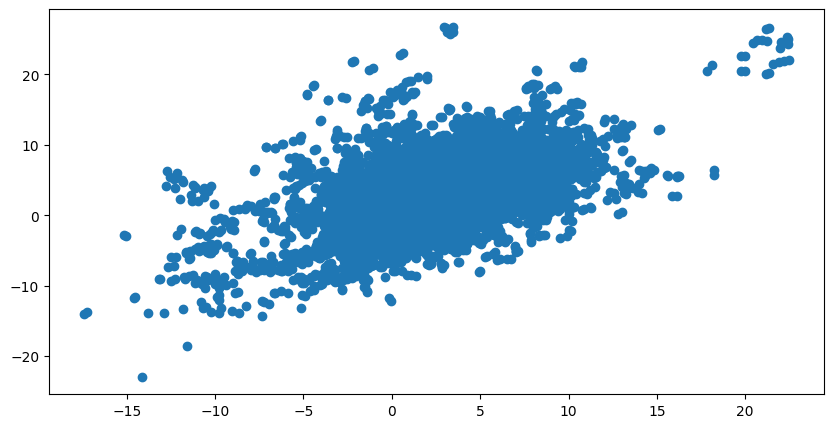

In [24]:
df = df[df['d_PSVarX'] < 4000]
df = df[df['d_PSVarY'] < 4000]
plt.figure(figsize=(10,5))
plt.scatter(df['d_PSVarX'],df['d_PSVarY'])

In [25]:
# df.to_excel('df_EDA.xlsx')

In [26]:
df = df[['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'MacNo',
         'MacRecipe', 'mtl_desc2', 'mtl_desc4', 'vend_nbr', 'layer_2Thick',
         'plate_mtl_desc1', 'plate_mtl_desc2', 'plate_vend_nbr',
         'plate_layer_2Thick', 'plate_RC_value', 'Residual_Copper_Rate',
         'glass_fabric_thickness_mm', 'use_cu_upper_thickness',
         'use_cu_lower_thickness', 'use_cu_type', 'glass_fabric_type', 'short',
         'long', 'bake_result', 'bake_measured', 'bake_after_browning_result',
         'bake_after_browning_measured', 'd_PSVarX', 'd_PSVarY']]
         #'Part_nbr_grouped', 'plate_RC_cat']]

In [27]:
df.describe()

,MacNo,mtl_desc2,layer_2Thick,plate_mtl_desc2,plate_layer_2Thick,plate_RC_value,Residual_Copper_Rate,glass_fabric_thickness_mm,short,long,bake_result,bake_measured,bake_after_browning_result,bake_after_browning_measured,d_PSVarX,d_PSVarY
count,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000,55017.000000
mean,7.741480,0.178084,6.380830,0.098250,5.686498,64.926986,0.687468,0.106510,1.000844,1.000546,1.936092,0.063908,1.427413,0.572587,3.496499,3.362699
std,9.091208,0.087285,3.055286,0.102887,3.950101,6.171236,0.203828,0.084324,0.008456,0.008452,0.244590,0.244590,0.494708,0.494708,2.256940,2.599113
min,1.000000,0.011000,0.750000,0.000000,2.060000,43.000000,0.000000,0.050000,0.010010,0.010006,1.000000,0.000000,1.000000,0.000000,-17.412000,-22.928000
25%,2.000000,0.147000,5.300000,0.000000,4.160000,62.000000,0.475064,0.080000,1.000690,1.000450,2.000000,0.000000,1.000000,0.000000,2.448000,2.028000
50%,3.000000,0.173000,6.160000,0.081000,5.040000,65.000000,0.803598,0.102000,1.000900,1.000550,2.000000,0.000000,1.000000,1.000000,3.629000,3.369000
75%,21.000000,0.183000,6.300000,0.152000,6.000000,70.000000,0.845176,0.110000,1.001150,1.000720,2.000000,0.000000,2.000000,1.000000,4.723000,4.705000
max,31.000000,2.400000,94.060000,1.193000,132.000000,78.000000,1.127272,2.400000,1.002330,1.002050,2.000000,1.000000,2.000000,1.000000,22.465000,26.772000


In [28]:
from scipy.stats import skew, kurtosis

numerical_features = [feature for feature in df.columns if df[feature].dtypes!='O']

skew = skew(df[numerical_features], bias= False )

skew_df = pd.DataFrame({'features': df[numerical_features].columns,
                        'skew':skew})

skew_df = skew_df.sort_values(by = 'skew', ascending = False).reset_index(drop=True)
skew_df

,features,skew
0,glass_fabric_thickness_mm,11.865408
1,layer_2Thick,10.603114
2,mtl_desc2,9.346825
3,plate_layer_2Thick,9.092875
4,bake_measured,3.566031
5,plate_mtl_desc2,1.458318
6,MacNo,1.064727
7,bake_after_browning_result,0.293463
8,d_PSVarY,0.187815
9,bake_after_browning_measured,-0.293463


In [29]:
kurtosis = kurtosis(df[numerical_features], bias= False )

kurtosis_df = pd.DataFrame({'features': df[numerical_features].columns,
                        'kurtosis':kurtosis})

kurtosis_df = kurtosis_df.sort_values(by = 'kurtosis', ascending = False).reset_index(drop=True)
kurtosis_df

,features,kurtosis
0,long,13717.151655
1,short,13704.412445
2,glass_fabric_thickness_mm,180.305396
3,plate_layer_2Thick,173.455094
4,layer_2Thick,158.604740
5,mtl_desc2,128.837509
6,bake_measured,10.716964
7,bake_result,10.716964
8,d_PSVarX,7.527274
9,d_PSVarY,7.093125


In [30]:
from scipy.stats import skew as sp_skew, kurtosis as sp_kurtosis

# 取前 20 個料號
top_parts = df['Part_nbr'].unique()[:30]
df_top20 = df[df['Part_nbr'].isin(top_parts)]

# 偏度與峰度計算
skew_kurt_list = []
for feature in numerical_features:
    for part in top_parts:
        vals = df_top20[df_top20['Part_nbr']==part][feature].dropna()
        if len(vals) > 1:
            skew_kurt_list.append({
                'Part_nbr': part,
                'feature': feature,
                'skew': sp_skew(vals, bias=False),
                'kurtosis': sp_kurtosis(vals, bias=False)
            })

skew_kurt_df = pd.DataFrame(skew_kurt_list)

# 畫圖也用 df_top20
# plt.figure(figsize=(12,6))
# sns.scatterplot(data=skew_kurt_df, x='skew', y='kurtosis', hue='feature')
# plt.title('Skew vs Kurtosis by Feature & Part Number (Top 20 Parts)')
# plt.show()


C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_15272\2252408560.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': sp_skew(vals, bias=False),
C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_15272\2252408560.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': sp_kurtosis(vals, bias=False)


In [31]:
skew_kurt_df = skew_kurt_df[skew_kurt_df['feature'] == 'plate_layer_2Thick']

In [32]:
# skew_kurt_df.to_excel('skew_kurt_df.xlsx')

In [33]:
for col in ['long','short','glass_fabric_thickness_mm','layer_2Thick','mtl_desc2']:
    print(col, df[col].describe())


long count    55017.000000
mean         1.000546
std          0.008452
min          0.010006
25%          1.000450
50%          1.000550
75%          1.000720
max          1.002050
Name: long, dtype: float64
short count    55017.000000
mean         1.000844
std          0.008456
min          0.010010
25%          1.000690
50%          1.000900
75%          1.001150
max          1.002330
Name: short, dtype: float64
glass_fabric_thickness_mm count    55017.000000
mean         0.106510
std          0.084324
min          0.050000
25%          0.080000
50%          0.102000
75%          0.110000
max          2.400000
Name: glass_fabric_thickness_mm, dtype: float64
layer_2Thick count    55017.000000
mean         6.380830
std          3.055286
min          0.750000
25%          5.300000
50%          6.160000
75%          6.300000
max         94.060000
Name: layer_2Thick, dtype: float64
mtl_desc2 count    55017.000000
mean         0.178084
std          0.087285
min          0.011000
25%       

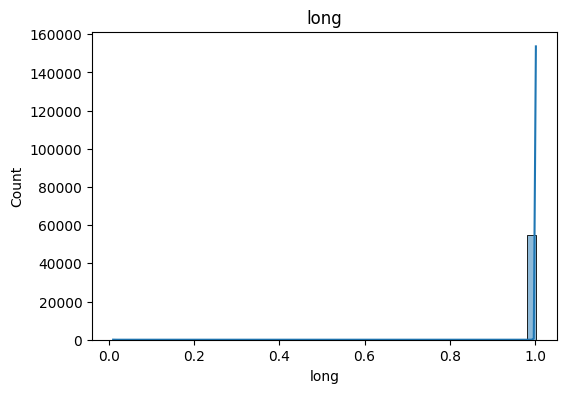

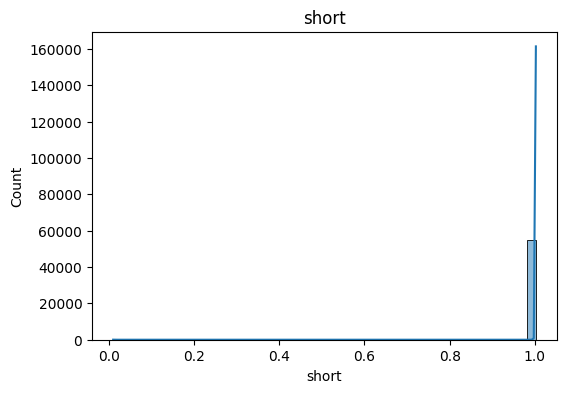

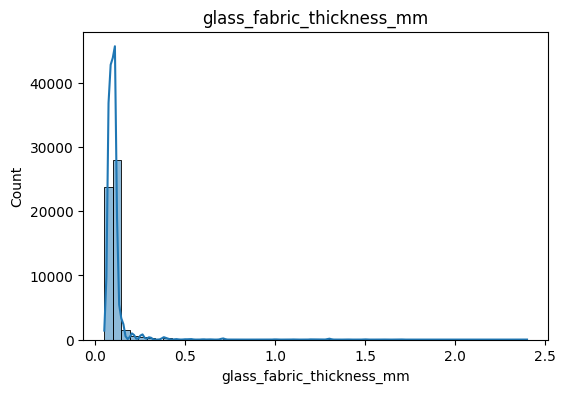

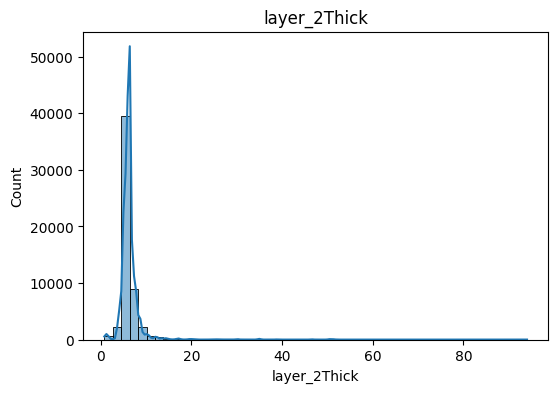

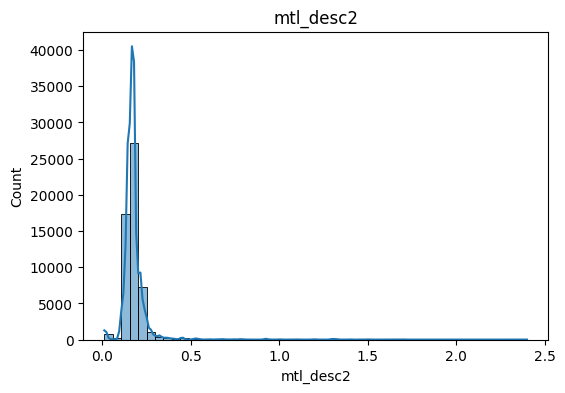

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['long','short','glass_fabric_thickness_mm','layer_2Thick','mtl_desc2']:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), bins=50, kde=True)
    plt.title(col)
    plt.show()


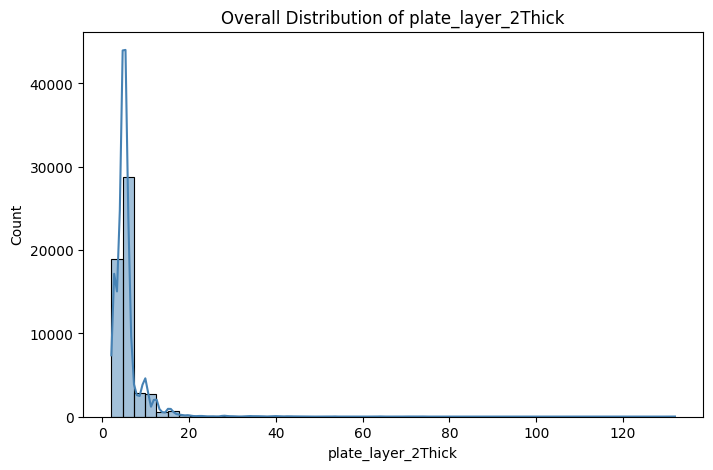

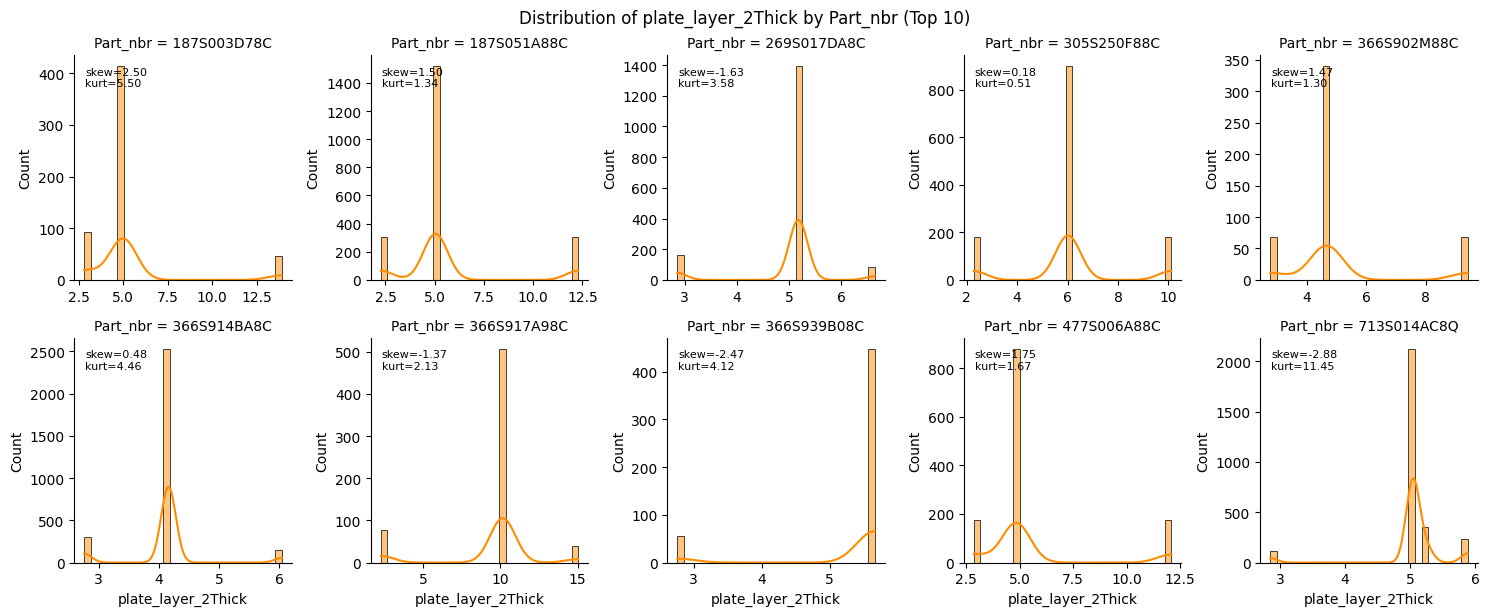

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假設你的數據在 df，欄位 feature 是你關注的連續變數，Part_nbr 是料號
feature = "plate_layer_2Thick"

# 1. 全體分布
plt.figure(figsize=(8,5))
sns.histplot(df[feature].dropna(), kde=True, bins=50, color="steelblue")
plt.title(f"Overall Distribution of {feature}")
plt.xlabel(feature)
plt.ylabel("Count")
plt.show()

# 2. 選前10個料號
top_parts = df['Part_nbr'].value_counts().head(10).index
df_subset = df[df['Part_nbr'].isin(top_parts)]

# 計算每個料號的 skew/kurtosis
stats_dict = {}
for part in top_parts:
    vals = df_subset[df_subset['Part_nbr'] == part][feature].dropna()
    if len(vals) > 1:
        stats_dict[part] = {
            "skew": sp_skew(vals),
            "kurt": sp_kurtosis(vals, fisher=True)  # fisher=True → excess kurtosis
        }
    else:
        stats_dict[part] = {"skew": float("nan"), "kurt": float("nan")}

# 畫 FacetGrid
g = sns.FacetGrid(df_subset, col="Part_nbr", col_wrap=5, height=3, sharex=False, sharey=False)

def annotate(data, color, **kws):
    part = data['Part_nbr'].iloc[0]
    s = stats_dict[part]["skew"]
    k = stats_dict[part]["kurt"]
    plt.gca().text(0.05, 0.95,
                   f"skew={s:.2f}\nkurt={k:.2f}",
                   transform=plt.gca().transAxes,
                   ha="left", va="top", fontsize=8, color="black")

g.map_dataframe(sns.histplot, feature, kde=True, bins=30, color="darkorange")
g.map_dataframe(annotate)

g.fig.suptitle(f"Distribution of {feature} by Part_nbr (Top 10)", y=1.02)
plt.show()


In [36]:
df.columns

Index(['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'MacNo', 'MacRecipe',
       'mtl_desc2', 'mtl_desc4', 'vend_nbr', 'layer_2Thick', 'plate_mtl_desc1',
       'plate_mtl_desc2', 'plate_vend_nbr', 'plate_layer_2Thick',
       'plate_RC_value', 'Residual_Copper_Rate', 'glass_fabric_thickness_mm',
       'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
       'glass_fabric_type', 'short', 'long', 'bake_result', 'bake_measured',
       'bake_after_browning_result', 'bake_after_browning_measured',
       'd_PSVarX', 'd_PSVarY'],
      dtype='object')

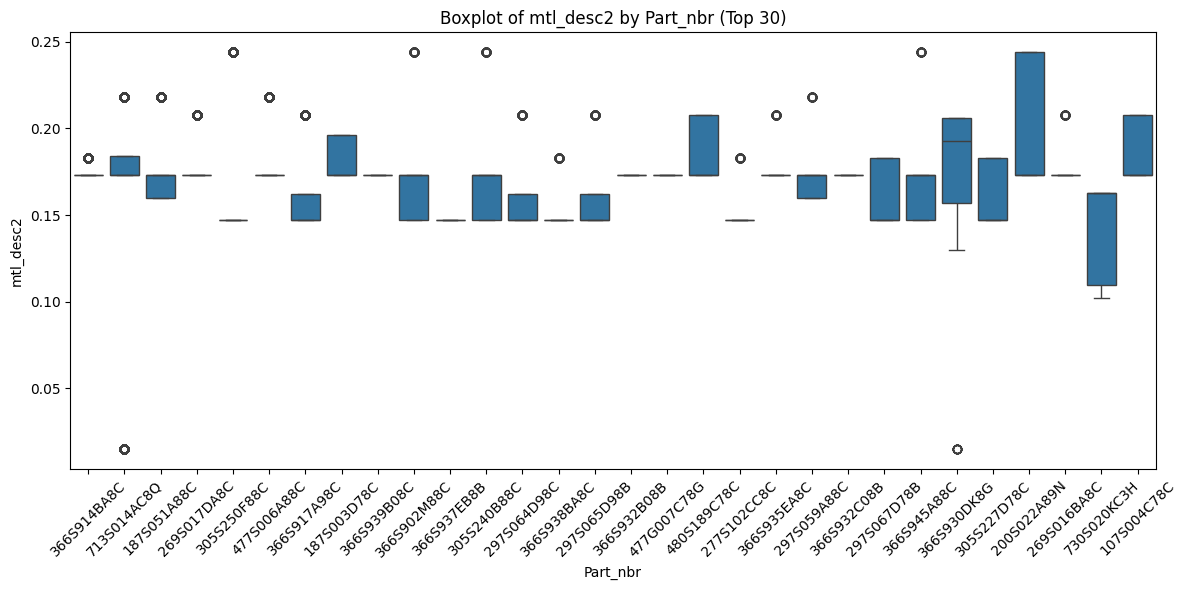

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假設 df 裡有 'Part_nbr' 和你要分析的特徵，例如 'Residual_Copper_Rate'
feature = "mtl_desc2"

# 取出前30個料號 (出現次數最多的前30個)
top_parts = df["Part_nbr"].value_counts().index[:30]
df_top = df[df["Part_nbr"].isin(top_parts)]

plt.figure(figsize=(12,6))
sns.boxplot(x="Part_nbr", y=feature, data=df_top, order=top_parts)

plt.title(f"Boxplot of {feature} by Part_nbr (Top 30)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [38]:
part_counts = df['Part_nbr'].value_counts()

top_parts = part_counts.head(30)

df_top30 = top_parts.reset_index()
df_top30.columns = ['Part_nbr', 'count']

df_top30

,Part_nbr,count
0,366S914BA8C,2980
1,713S014AC8Q,2832
2,187S051A88C,2128
3,269S017DA8C,1640
4,305S250F88C,1260
5,477S006A88C,1232
6,366S917A98C,624
7,187S003D78C,552
8,366S939B08C,504
9,366S902M88C,476


In [39]:
# import pandas as pd
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# # 計算每個料號樣本數
# part_counts = df['Part_nbr'].value_counts()

# # 取前30個樣本數最大的料號
# top30_parts = part_counts.head(30).index

# # 篩選資料，只保留這些料號
# df_top30 = df[df['Part_nbr'].isin(top30_parts)][['Part_nbr', 'plate_vend_nbr', 'Residual_Copper_Rate', 'd_PSVarX']].dropna()

# # 建立 ANOVA 公式
# formula = 'd_PSVarX ~  Residual_Copper_Rate + C(plate_vend_nbr) '

# # fit ANOVA model
# model = ols(formula, data=df_top30).fit()

# # 取得 ANOVA table
# anova_table = sm.stats.anova_lm(model, typ=2)  # typ=2 可得 SS, df, MS
# print(anova_table)


In [40]:
# df[df["Part_nbr"]=='366S914BA8C']['plate_mtl_desc2']
df["glass_fabric_type"].unique()

array(['2116*1', '106*2', '3313*1', '1078*1', '1506*1', '1035*2',
       '1037*2', '3313*3', '1086*1', '7628*7', '1067*2', '1078*2',
       'Missing', '7628*3', '2116*6', '2116*2', '7628*2', '7628*1',
       '1067*1', '2116*10', '3313*2', '7628*4', '2116*3', '1086*2',
       '1027*2', '3313*4', '2112*1', '1506*2', '7628*13', '7628*9',
       '2116*6+3313*2', '2116*5', '1080*2', '7628*6', '3313*8', '3313*13',
       '2113*1', '2', '1035*1', '1080*1', '1080*1+7628*2',
       '2116*6+2113*2', '2113*2', '7628*8', 'RTF-7628*5', '2155*2',
       '2116*4', '7628*5', '7628*2+1080*1', '7627*1', '2116*14', '2116*9',
       '106*1', '2116*16', 'HTE-2116*1', '1086X1', '7628*11', '7628*10',
       'RG312+1078*2', '1080*2-RTF', '3313*14', '7629*2', '1*3313',
       '1080*1+1652*2'], dtype=object)

In [41]:
df.columns

Index(['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'MacNo', 'MacRecipe',
       'mtl_desc2', 'mtl_desc4', 'vend_nbr', 'layer_2Thick', 'plate_mtl_desc1',
       'plate_mtl_desc2', 'plate_vend_nbr', 'plate_layer_2Thick',
       'plate_RC_value', 'Residual_Copper_Rate', 'glass_fabric_thickness_mm',
       'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
       'glass_fabric_type', 'short', 'long', 'bake_result', 'bake_measured',
       'bake_after_browning_result', 'bake_after_browning_measured',
       'd_PSVarX', 'd_PSVarY'],
      dtype='object')

C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_15272\2562254902.py:13: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_15272\2562254902.py:13: UserWarning: Glyph 20126 (\N{CJK UNIFIED IDEOGRAPH-4E9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_15272\2562254902.py:13: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_15272\2562254902.py:13: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_15272\2562254902.py:13: UserWarning: Glyph 29183 (\N{CJK UNIFIED IDEOGRAPH-71FF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_15272\2562254902.py:1

<Figure size 1400x600 with 0 Axes>

C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20126 (\N{CJK UNIFIED IDEOGRAPH-4E9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wilson_liu\AppD

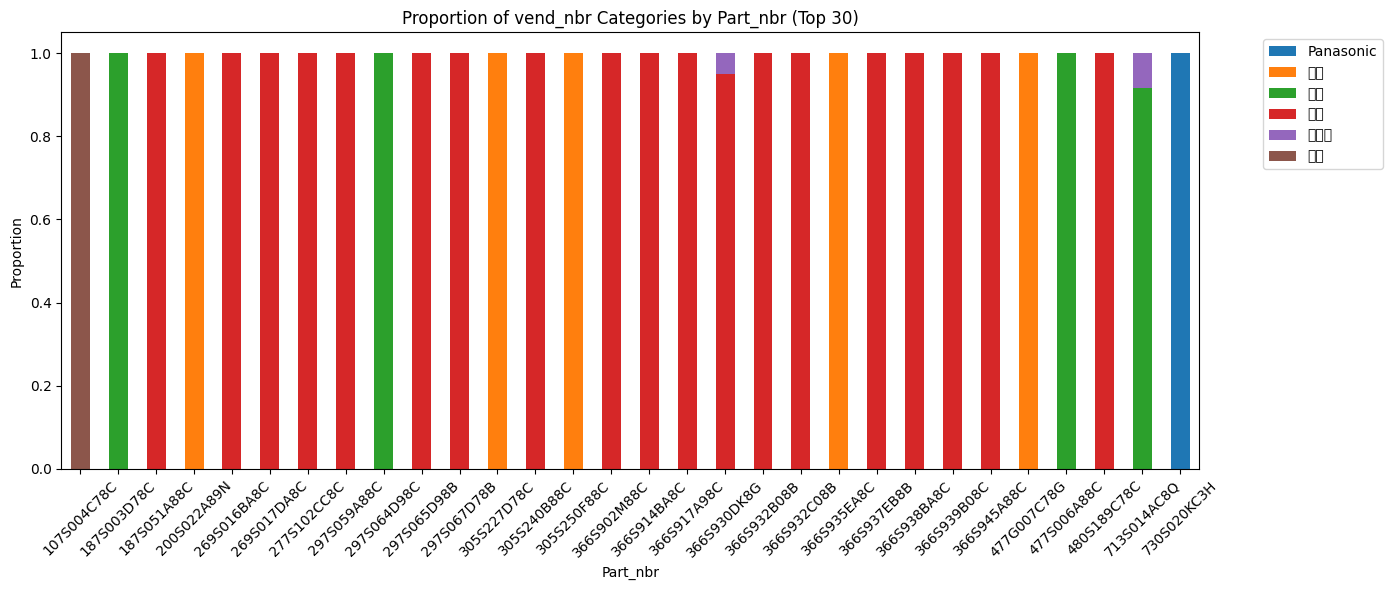

C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20126 (\N{CJK UNIFIED IDEOGRAPH-4E9E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 29183 (\N{CJK UNIFIED IDEOGRAPH-71FF})

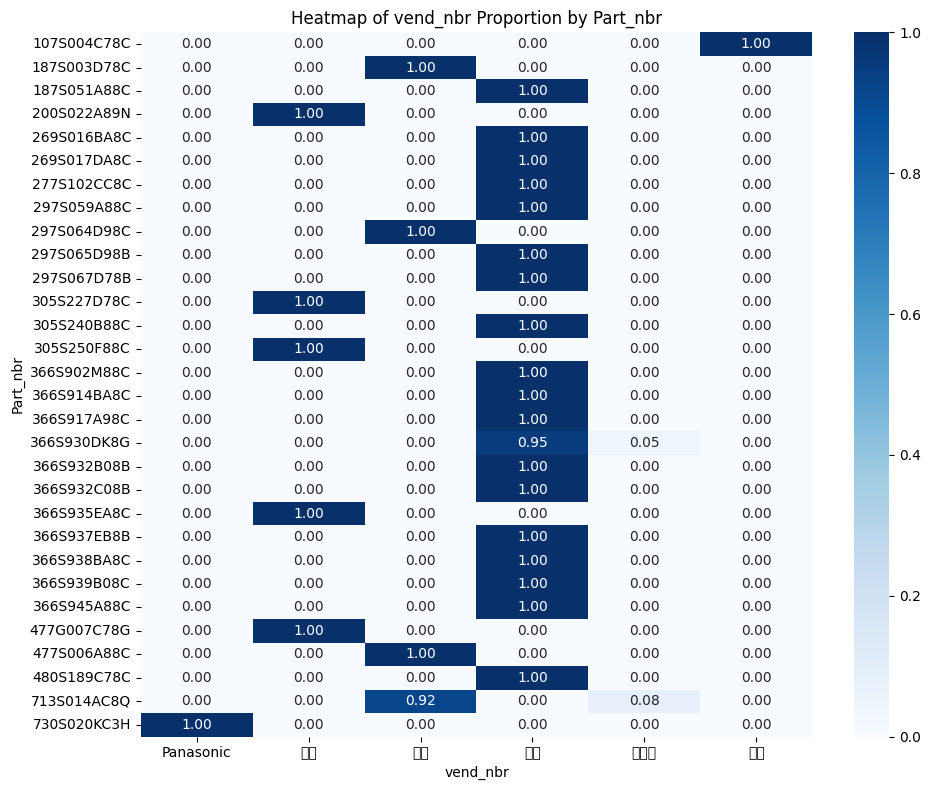

In [42]:
feature = "vend_nbr" # 一個類別特徵

# 1. 計算每個料號中，各個類別的占比
cross_tab = pd.crosstab(df_top['Part_nbr'], df_top[feature], normalize='index')

# 2. 繪製堆疊條形圖
plt.figure(figsize=(14, 6))
cross_tab.plot(kind='bar', stacked=True, figsize=(14,6))
plt.title(f'Proportion of {feature} Categories by Part_nbr (Top 30)')
plt.ylabel('Proportion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. 或者繪製熱力圖（更適合類別數少的情況）
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.2f')
plt.title(f'Heatmap of {feature} Proportion by Part_nbr')
plt.tight_layout()
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

feature_scale = [
    'mtl_desc2', 'layer_2Thick', 'plate_layer_2Thick', 'Residual_Copper_Rate', 
    'glass_fabric_thickness_mm', 'short', 'long'
]

feature_scale = [feature for feature in feature_scale if feature in df.columns]

df_scaled = df.copy()

# ---- 以料號群組做 MinMax ----
for feat in feature_scale:
    df_scaled[feat] = df_scaled.groupby("Part_nbr")[feat].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )


In [50]:
within_var = df_scaled.groupby('Part_nbr')[['mtl_desc2', 'layer_2Thick', 'plate_layer_2Thick', 'Residual_Copper_Rate', 
                'glass_fabric_thickness_mm',  'short', 'long']].var()
within_var.iloc[:30,:]

,mtl_desc2,layer_2Thick,plate_layer_2Thick,Residual_Copper_Rate,glass_fabric_thickness_mm,short,long
Part_nbr,,,,,,,
107S004C78C,0.223256,0.223256,0.068941,0.201295,0.000000,0.000000,0.000000
107S009A78C,0.228571,0.228571,0.084333,0.180151,0.228571,0.128819,0.142938
107S011A38C,0.000000,0.000000,0.214286,0.233236,0.000000,0.285714,0.285714
107S013B08C,0.085271,0.084121,0.100386,0.176673,0.076190,0.130342,0.109028
107S013C08C,0.087779,0.086596,0.103338,0.187880,0.078431,0.000000,0.000000
107S014C08C,0.087779,0.086596,0.104514,0.187324,0.084967,0.121772,0.149918
110EB58B38F,0.000000,0.000000,0.195652,0.138642,0.000000,0.000000,0.000000
110EB64C3BF,0.000000,0.000000,0.214286,0.265480,0.000000,0.000000,0.000000
110EB74D73C,0.176453,0.177536,0.058475,0.167324,0.231884,0.180354,0.177536


In [49]:
betwwn_var = df_scaled[['mtl_desc2', 'layer_2Thick', 'plate_layer_2Thick', 'Residual_Copper_Rate', 
                'glass_fabric_thickness_mm',  'short', 'long']].var()
betwwn_var

mtl_desc2                    0.179663
layer_2Thick                 0.178501
plate_layer_2Thick           0.144827
Residual_Copper_Rate         0.185913
glass_fabric_thickness_mm    0.201590
short                        0.162101
long                         0.154514
dtype: float64